# Optics calculation and matching for a large ring (LHC) - part 1

%matplotlib widget

In [1]:
import xtrack as xt

import numpy as np
import matplotlib.pyplot as plt
from util.constants import HLLHC15_THICK_PATH, OPT_150_1500_PATH

### Load LHC model

In [2]:
collider = xt.Multiline.from_json(HLLHC15_THICK_PATH)
collider.vars.load_madx_optics_file(OPT_150_1500_PATH)

collider.build_trackers()

Loading line from dict: 100%|██████████| 29009/29009 [00:02<00:00, 12035.60it/s]


Done loading line from dict.           


### Initial twiss

In [3]:
tw0 = collider.lhcb1.twiss()

In [4]:
# Inspect IPS
tw0.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name            betx          bety           mux           muy             x             y
ip1             0.15          0.15             0             0             0             0
ip2               10            10       8.23376        7.6927  -1.85096e-18  -1.44445e-34
ip3          121.567       218.584       15.9494       15.4503   6.91384e-16  -6.43523e-35
ip4           236.18       306.197        23.507       22.3832  -4.60828e-16   5.83486e-34
ip5             0.15          0.15       30.9305       29.9889   1.34925e-17   1.01359e-35
ip6          273.434        183.74       38.7487       37.3936    4.0662e-16    3.7598e-34
ip7          120.813       149.431       46.3524       44.5934  -1.37417e-16  -9.06447e-34
ip8              1.5           1.5       54.3432       52.2729  -3.49427e-17   3.46667e-33
ip1.l1          0.15          0.15         62.31         60.32  -7.49865e-18   1.39821e-33

### Prepare for optics matching: set limits and steps for all circuits

In [5]:
import lhc_match as lm
lm.set_var_limits_and_steps(collider)

In [6]:
# Inspect for one circuit
collider.vars.vary_default['kq4.l2b2']

{'step': 1e-06, 'limits': (0.00020557714282348692, 0.0068525714274495645)}

### Twiss on a part of the machine (bidirectional)

In [7]:
tw_81_12 = collider.lhcb1.twiss(start='ip8', end='ip2', init_at='ip1',
                                betx=0.15, bety=0.15)

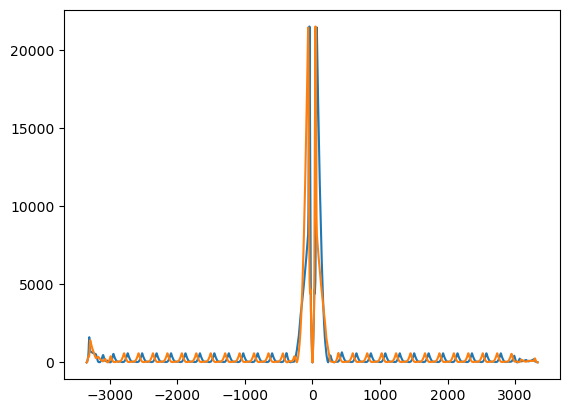

In [8]:
plt.figure()
plt.plot(tw_81_12.s, tw_81_12.betx)
plt.plot(tw_81_12.s, tw_81_12.bety)

### Telescopic rematch of IP1 using IP2 and IP8

#### Match left side

#### Define Optimizer and Merit Function

In [9]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='s.ds.l8.b1', end='ip1',
    init=tw0, init_at=xt.START,
    vary=[
        # Only IR8 quadrupoles including DS
        xt.VaryList(['kq6.l8b1', 'kq7.l8b1', 'kq8.l8b1', 'kq9.l8b1', 'kq10.l8b1', 
            'kqtl11.l8b1', 'kqt12.l8b1', 'kqt13.l8b1',
            'kq4.l8b1', 'kq5.l8b1', 'kq4.r8b1', 'kq5.r8b1', 
            'kq6.r8b1', 'kq7.r8b1', 'kq8.r8b1', 'kq9.r8b1', 
            'kq10.r8b1', 'kqtl11.r8b1', 'kqt12.r8b1', 'kqt13.r8b1'])],
    targets=[
        xt.TargetSet(at='ip8', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetSet(at='ip1', betx=0.15, bety=0.1, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'ip1.l1'] - tw0['mux', 's.ds.l8.b1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'ip1.l1'] - tw0['muy', 's.ds.l8.b1']), 
    ])

In [10]:
merit_function = opt.get_merit_function(return_scalar=False, check_limits=False)
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [71]:
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.operators.sampling.lhs import LHS

n_var = 20
n_obj = 14

class MyProblem(Problem):

    def __init__(self, surrogate=None):
        super().__init__(n_var=n_var, 
                         n_obj=n_obj, 
                         n_constr=0, 
                         xl=bounds[:,0],  # Lower bounds
                         xu=bounds[:,1])   # Upper bounds
        self.surrogate = surrogate

    def _evaluate(self, x, out, *args, **kwargs):
        if self.surrogate:
            # Use surrogate to predict the objective function values
            out["F"] = self.surrogate.predict(x)
        else:
            out["F"] = np.array([merit_function(x_i)**2 for x_i in x])

problem = MyProblem()

In [72]:
pop_size = 15
n_gen = 100
n_partitions = 1

sample = LHS()
sample_x = sample(problem, pop_size - 1).get("X")
initial_population = np.vstack([x0, sample_x])
ref_dirs = get_reference_directions("das-dennis", n_obj, n_partitions=1)
algorithm = NSGA3(pop_size=pop_size, ref_dirs=ref_dirs)

In [73]:
ref_dirs

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [74]:
res = minimize(problem,
               algorithm,
               termination=('n_gen', n_gen),
               seed=1,
               sampling=initial_population,
               #mutation=PolynomialMutation(prob=1.0 / n_var, eta=20),
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       15 |      3 |             - |             -
     2 |       30 |      2 |  1.150257E+01 |         ideal
     3 |       45 |      4 |  0.0498283312 |         ideal
     4 |       60 |      3 |  0.0030473637 |         ideal
     5 |       75 |      4 |  0.0278392269 |         ideal
     6 |       90 |      5 |  0.4897985326 |         ideal
     7 |      105 |      5 |  0.1132692294 |         ideal
     8 |      120 |      4 |  0.0371566751 |         ideal
     9 |      135 |      3 |  0.1256143082 |         ideal
    10 |      150 |      3 |  1.0000000000 |         ideal
    11 |      165 |      4 |  0.5197136674 |         ideal
    12 |      180 |      3 |  5.5741375573 |         ideal
    13 |      195 |      4 |  0.4547484137 |         ideal
    14 |      210 |      2 |  1.3943004694 |         ideal
    15 |      225 |      2 |  0.000000E+00 |             f
    16 |      240 |      3 |  0.2636467898 |         ide

In [78]:
merit_function(res.X[3])

array([ 5.79458681e+01, -1.02007791e+00,  8.74244004e+00, -2.51225920e+01,
        1.22759055e+00,  3.30770801e-01,  8.88679519e+00,  4.03812506e+03,
        9.54559259e+00, -1.52741610e+05,  5.82730102e-01,  7.87222330e+00,
       -9.76812313e-02, -2.34558879e-01])

In [81]:
opt.target_status()

Target status:                             
id state tag tol_met       residue   current_val    target_val description                                 
 0 ON          False       57.9459       59.4459           1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
 1 ON          False      -1.02008      0.479922           1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
 2 ON          False      0.874244      0.874244   2.20333e-07 line=lhcb1, ('alfx', 'ip8'), val=2.20333 ...
 3 ON          False      -2.51226      -2.51226   2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
 4 ON          False      0.122759      0.122759   1.18964e-09 line=lhcb1, ('dx', 'ip8'), val=1.18964e- ...
 5 ON          False    0.00330771    0.00330771   1.57025e-10 line=lhcb1, ('dpx', 'ip8'), val=1.57025e ...
 6 ON          False        8.8868        9.0368          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
 7 ON          False       4038.13       4038.23           0.1 line=lhcb1, ('bety', 'ip1'), 

In [80]:
merit_function.set_x(res.X[3])

In [12]:
# Import NumPy Arrays
#x_arr = np.load("../../pymoo_complex_x_pop_400_ngen_800_refpart_2.npy")
#f_arr = np.load("../../pymoo_complex_f_pop_400_ngen_800_refpart_2.npy")

In [13]:
f_arr.shape

(14, 14)

In [15]:
f_arr

array([[1.34980712e+02, 1.31455857e+00, 4.38022656e+01, 4.66579508e-01,
        2.34701903e-05, 1.53009185e-06, 1.37066553e+01, 5.00545927e+01,
        2.98190296e+01, 8.89539991e+04, 3.36612150e-04, 7.20962995e-05,
        1.14796283e-02, 2.45420851e-05],
       [1.61168382e+01, 8.58355821e+04, 1.54945602e+02, 7.85335651e+00,
        6.01750409e-05, 1.86391613e-06, 3.25829974e+00, 5.55885963e+01,
        2.79002842e+03, 3.88122509e+03, 6.86038034e-03, 2.25520222e-04,
        1.99613018e-04, 1.54225166e-06],
       [9.78306380e-01, 3.55027969e-02, 5.64835044e+00, 2.94212101e+01,
        8.32115064e-06, 5.01250898e-07, 1.72667357e+01, 5.13519926e+02,
        1.54557023e+03, 1.74181151e+06, 3.74928048e-04, 2.20181758e-04,
        1.29505382e-01, 5.09164755e-08],
       [1.00027910e+00, 9.90884421e-01, 6.04913785e+01, 1.13242080e+02,
        3.16921336e-04, 1.07185777e-06, 9.45435114e+00, 3.94778622e+01,
        4.79986692e+06, 4.04317720e+04, 7.52593603e-03, 7.28756809e-01,
        4.807

In [77]:
np.argmin(np.sum(res.F, axis=1))

np.int64(3)

In [17]:
np.sum(f_arr**2, axis=1)

array([7.91283769e+09, 7.39062276e+09, 3.03391000e+12, 2.30403572e+13,
       1.68887154e+08, 1.07277394e+07, 5.20968959e+08, 5.09922923e+08,
       6.40636659e+10, 9.80753823e+11, 5.52900899e+12, 5.59934627e+07,
       1.05053599e+11, 4.99976616e+09])

In [19]:
merit_function(x_arr[5])

array([ 4.63829287e+00,  9.37407502e-01,  5.36381587e+00, -1.44147728e+01,
       -1.46581146e-01, -3.86060299e-02,  5.31047198e-01,  5.56416713e-01,
       -5.66006830e+01, -2.54570091e+01,  3.82873540e-02,  1.53952953e+01,
        4.02354316e-01, -3.92813245e-03])

In [31]:
opt.reload(0)

In [33]:
opt.target_status()

Target status:                           
id state tag tol_met       residue   current_val    target_val description                                 
 0 ON           True  -4.50736e-10           1.5           1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
 1 ON           True  -5.73919e-11           1.5           1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
 2 ON           True   1.92585e-10   2.20526e-07   2.20333e-07 line=lhcb1, ('alfx', 'ip8'), val=2.20333 ...
 3 ON           True   1.87368e-12   2.15516e-07   2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
 4 ON           True   6.97608e-10   1.88725e-09   1.18964e-09 line=lhcb1, ('dx', 'ip8'), val=1.18964e- ...
 5 ON           True   1.16554e-09   1.32257e-09   1.57025e-10 line=lhcb1, ('dpx', 'ip8'), val=1.57025e ...
 6 ON           True  -5.42685e-08          0.15          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
 7 ON          False          0.05          0.15           0.1 line=lhcb1, ('bety', 'ip1'), va